# Ungraded Lab - Trees Ensemble

In this notebook, you will:

 - Use Pandas to perform one-hot encoding of a dataset
 - Use scikit-learn to implement a Decision Tree, Random Forest and XGBoost models

Let's import the libraries we will use.

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# 1. Introduction

#### Datatset
- This dataset is obtained from Kaggle: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

#### Context
- Cardiovascular disease (CVDs) is the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs.
- People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management.  
- This dataset contains 11 features that can be used to predict possible heart disease.
- Let's train a machine learning model to assist with diagnosing this disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As we can see above, the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so we must one-hot encode them. 

In [3]:
# Load the dataset using pandas
df = pd.read_csv("heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We must perform some data engineering before working with the models. There are 5 categorical features, so we will use Pandas to one-hot encode them.

## 2. One-hot encoding using Pandas

First we will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this we will just count how many different values there are in each categorical variable and **consider only the variables with 3 or more values**.

In [5]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

As a reminder, one-hot encoding aims to **transform a categorical variable with `n` outputs into `n` binary variables**.

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here we will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so we know which value we are dealing with
 - columns: the list of columns that **will be one-hot encoded**. 'prefix' and 'columns' must have the same length.
 
For more information, you can always type `help(pd.get_dummies)` to read the function's full documentation.

In [6]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                         prefix = cat_variables,
                         columns = cat_variables)

In [7]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Let's choose the variables that will be the input features of the model.
- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`.

In [8]:
features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our TARGET variable

We started with 11 features.  Let's see how many feature variables we have after one-hot encoding.

In [9]:
print(len(features))

20


# 3. Splitting the Dataset

In this section, we will split our dataset into train and test datasets. We will use the function `train_test_split` from Scikit-learn. Let's just check its arguments.

In [10]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to 

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

# We will keep the shuffle = True since our dataset has not any TIME DEPENDENCY.

In [12]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5518


# 4. Building the Models

## 4.1 Decision Tree

In this section, let's work with the Decision Tree we previously learned, but now using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

There are several hyperparameters in the Decision Tree object from Scikit-learn. We will use only some of them and also we will not perform **feature selection** nor **hyperparameter tuning** in this lab (but you are encouraged to do so and compare the results 😄 )

The hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a **HIGHER min_samples_split** can reduce the number of splits and may help to **reduce overfitting**.
 - max_depth: The maximum depth of the tree. 
   - Choosing a **LOWER max_depth** can reduce the number of splits and may help to **reduce overfitting**.

In [13]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

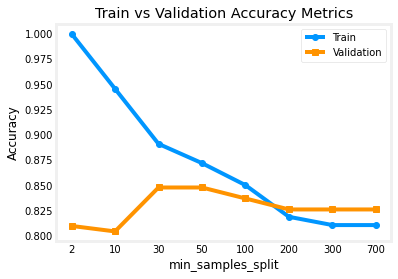

In [14]:
# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Iterate over each value in min_samples_split_list to evaluate different splits
for min_samples_split in min_samples_split_list:
    # Initialize the Decision Tree model with the current min_samples_split value
    # random_state ensures reproducibility of results
    # The fit method trains the model on the training data (X_train, y_train)
    model = DecisionTreeClassifier(
        min_samples_split=min_samples_split,
        random_state=RANDOM_STATE
    ).fit(X_train, y_train)
    
    # Predict the labels for the training dataset using the trained model
    predictions_train = model.predict(X_train)  # Predicted values for the training set
    
    # Predict the labels for the validation dataset using the trained model
    predictions_val = model.predict(X_val)      # Predicted values for the validation set
    
    # Calculate the accuracy of the model on the training dataset
    # accuracy_score compares the predicted labels with the true labels (y_train)
    accuracy_train = accuracy_score(predictions_train, y_train)
    
    # Calculate the accuracy of the model on the validation dataset
    # accuracy_score compares the predicted labels with the true labels (y_val)
    accuracy_val = accuracy_score(predictions_val, y_val)
    
    # Append the training accuracy to the accuracy_list_train
    accuracy_list_train.append(accuracy_train)
    
    # Append the validation accuracy to the accuracy_list_val
    accuracy_list_val.append(accuracy_val)

# Set the title of the plot
plt.title('Train vs Validation Accuracy Metrics')

# Label the x-axis with the parameter being varied
plt.xlabel('min_samples_split')

# Label the y-axis with the metric being measured
plt.ylabel('Accuracy')

# Define the positions and labels for the x-ticks based on the number of min_samples_split values
plt.xticks(
    ticks=range(len(min_samples_split_list)),
    labels=min_samples_split_list
)

# Plot the training accuracy scores
plt.plot(accuracy_list_train, marker='o', label='Train')

# Plot the validation accuracy scores
plt.plot(accuracy_list_val, marker='s', label='Validation')

# Add a legend to distinguish between training and validation plots
plt.legend(['Train', 'Validation'])

# Display the plot
plt.show()


Note how increasing the the number of `min_samples_split` reduces overfitting.
- Increasing `min_samples_split` from 10 to 30, and from 30 to 50, even though it does not improve the validation accuracy, it brings the training accuracy closer to it, showing a reduction in overfitting.

Let's do the same experiment with `max_depth`.

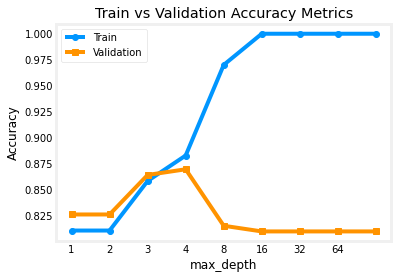

In [15]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Iterate over each value in max_depth_list to evaluate different tree depths
for max_depth in max_depth_list:
    # Initialize the Decision Tree model with the current max_depth value
    # random_state ensures reproducibility of results
    # The fit method trains the model on the training data (X_train, y_train)
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=RANDOM_STATE
    ).fit(X_train, y_train)
    
    # Predict the labels for the training dataset using the trained model
    predictions_train = model.predict(X_train)  # Predicted values for the training set
    
    # Predict the labels for the validation dataset using the trained model
    predictions_val = model.predict(X_val)      # Predicted values for the validation set
    
    # Calculate the accuracy of the model on the training dataset
    # accuracy_score compares the predicted labels with the true labels (y_train)
    accuracy_train = accuracy_score(predictions_train, y_train)
    
    # Calculate the accuracy of the model on the validation dataset
    # accuracy_score compares the predicted labels with the true labels (y_val)
    accuracy_val = accuracy_score(predictions_val, y_val)
    
    # Append the training accuracy to the accuracy_list_train
    accuracy_list_train.append(accuracy_train)
    
    # Append the validation accuracy to the accuracy_list_val
    accuracy_list_val.append(accuracy_val)

# Set the title of the plot
plt.title('Train vs Validation Accuracy Metrics')

# Label the x-axis with the parameter being varied
plt.xlabel('max_depth')

# Label the y-axis with the metric being measured
plt.ylabel('Accuracy')

# Define the positions and labels for the x-ticks based on the number of max_depth values
plt.xticks(
    ticks=range(len(max_depth_list)),
    labels=max_depth_list
)

# Plot the training accuracy scores
plt.plot(accuracy_list_train, marker='o', label='Train')

# Plot the validation accuracy scores
plt.plot(accuracy_list_val, marker='s', label='Validation')

# Add a legend to distinguish between training and validation plots
plt.legend(['Train', 'Validation'])

# Display the plot
plt.show()


We can see that in general, reducing `max_depth` can help to reduce overfitting.
- Reducing `max_depth` from 8 to 4 increases validation accuracy closer to training accuracy, while significantly reducing training accuracy.
- The validation accuracy reaches the highest at tree_depth=4. 
- When the `max_depth` is smaller than 3, both training and validation accuracy decreases.  The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). 
- When the `max_depth` is too high ( >= 5), validation accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

So we can choose the best values for these two hyper-parameters for our model to be:
- `max_depth = 4`
- `min_samples_split = 50` 

In [16]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [17]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


In [18]:
# Check the number of features in the original dataset
print("Original number of features in df:", df.shape[1])

# After splitting, check the number of features in X_train and X_val
print("Number of features in X_train:", X_train.shape[1])
print("Number of features in X_val:", X_val.shape[1])


Original number of features in df: 21
Number of features in X_train: 20
Number of features in X_val: 20


No sign of overfitting, even though the metrics are not that good.

### Adjusted Code for (1) Feature Selection and (2) Hyperparameter Tuning

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class RandomFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Randomly selects a specified number of features from the dataset.

    Parameters:
    -----------
    k : int
        Number of features to select randomly.
    random_state : int, RandomState instance or None, default=None
        Controls the randomness of the feature selection.
    """
    
    def __init__(self, k, random_state=None):
        self.k = k
        self.random_state = random_state
    
    def fit(self, X, y=None):
        """
        Fit the transformer on the data.

        Parameters:
        -----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            The input samples.
        y : Ignored
            Not used, present for API consistency by convention.

        Returns:
        --------
        self : object
            Returns self.
        """
        # Determine the number of features in the dataset
        n_features = X.shape[1]
        
        # Validate that k does not exceed the number of available features
        if self.k > n_features:
            raise ValueError(f"Cannot select {self.k} features as the dataset only has {n_features} features.")
        
        # Initialize the random number generator
        self.random_state_ = np.random.RandomState(self.random_state)
        
        # Randomly select feature indices without replacement
        self.selected_indices_ = self.random_state_.choice(n_features, self.k, replace=False)
        
        # If X is a DataFrame, store the selected feature names
        if isinstance(X, pd.DataFrame):
            self.selected_features_ = X.columns[self.selected_indices_].tolist()
        else:
            self.selected_features_ = self.selected_indices_
        
        return self
    
    def transform(self, X):
        """
        Transform the dataset by selecting the randomly chosen features.

        Parameters:
        -----------
        X : array-like or pandas DataFrame, shape (n_samples, n_features)
            The input samples.

        Returns:
        --------
        X_transformed : array-like or pandas DataFrame, shape (n_samples, k)
            The dataset with only the selected features.
        """
        # If X is a DataFrame, select columns by name
        if isinstance(X, pd.DataFrame):
            return X[self.selected_features_]
        else:
            # Otherwise, select columns by index
            return X[:, self.selected_indices_]

Number of features available for selection: 20
Number of top features to select (k_features): 5
Top 5 Hyperparameter Combinations Based on Validation Accuracy:
    max_depth  min_samples_split  Training Accuracy  Validation Accuracy
34        8.0                 30           0.826975             0.815217
36        8.0                100           0.801090             0.788043
52       32.0                100           0.801090             0.788043
38        8.0                300           0.783379             0.788043
20        3.0                100           0.784741             0.788043


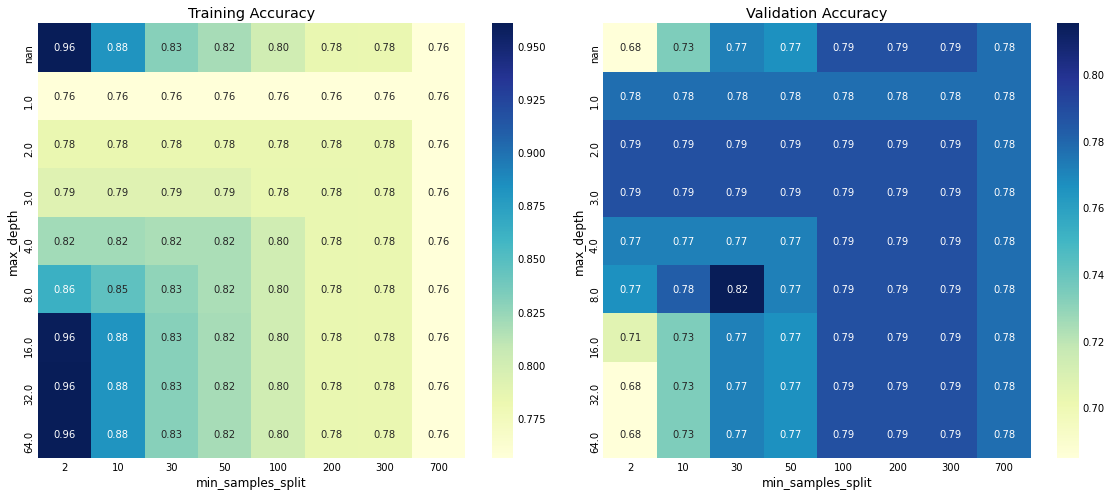


Best Hyperparameters Based on Validation Accuracy:
Max Depth: 8.0
Min Samples Split: 30.0
Validation Accuracy: 0.82


In [20]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Define the number of top features to select randomly
# Dynamically set k_features based on available features
desired_k_features = 5  # Desired number of features to select
actual_num_features = X_train.shape[1]
k_features = min(desired_k_features, actual_num_features)  # Ensure k_features <= n_features


print(f"Number of features available for selection: {actual_num_features}")
print(f"Number of top features to select (k_features): {k_features}")

# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Initialize lists to keep track of the corresponding hyperparameters
selected_max_depth = []
selected_min_samples_split = []

# Feature Selection and Hyperparameter Tuning using a Pipeline
for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        # Create a pipeline that first selects k_features randomly, then fits the Decision Tree
        pipeline = Pipeline([
            ('feature_selection', RandomFeatureSelector(k=k_features, random_state=42)),
            # DecisionTreeClassifier (simple, single tree) vs. RandomForestClassifier (complex, ensemble of multiple trees)
            ('classifier', DecisionTreeClassifier( 
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            ))
        ])
        
        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)
        
        # Predict the labels for the training dataset
        predictions_train = pipeline.predict(X_train)  # Predicted values for the training set
        
        # Predict the labels for the validation dataset
        predictions_val = pipeline.predict(X_val)      # Predicted values for the validation set
        
        # Calculate the accuracy on the training dataset
        accuracy_train = accuracy_score(y_train, predictions_train)
        
        # Calculate the accuracy on the validation dataset
        accuracy_val = accuracy_score(y_val, predictions_val)
        
        # Append the accuracies to the respective lists
        accuracy_list_train.append(accuracy_train)
        accuracy_list_val.append(accuracy_val)
        
        # Keep track of the hyperparameters used
        selected_max_depth.append(max_depth)
        selected_min_samples_split.append(min_samples_split)

# Convert the results into a DataFrame for easier analysis
results = pd.DataFrame({
    'max_depth': selected_max_depth,
    'min_samples_split': selected_min_samples_split,
    'Training Accuracy': accuracy_list_train,
    'Validation Accuracy': accuracy_list_val
})

# Display the top 5 results sorted by highest validation accuracy
print("Top 5 Hyperparameter Combinations Based on Validation Accuracy:")
print(results.sort_values(by='Validation Accuracy', ascending=False).head())

# Plotting the results
# To visualize how different hyperparameters affect the accuracy, we'll create heatmaps

# Pivot the DataFrame to create matrices for heatmaps
train_pivot = results.pivot("max_depth", "min_samples_split", "Training Accuracy")
val_pivot = results.pivot("max_depth", "min_samples_split", "Validation Accuracy")

# Set up the matplotlib figure
plt.figure(figsize=(16, 7))

# Heatmap for Training Accuracy
plt.subplot(1, 2, 1)
sns.heatmap(train_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Training Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')

# Heatmap for Validation Accuracy
plt.subplot(1, 2, 2)
sns.heatmap(val_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Validation Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Identify the best hyperparameters based on validation accuracy
best_index = results['Validation Accuracy'].idxmax()
best_params = results.loc[best_index, ['max_depth', 'min_samples_split']]
best_accuracy = results.loc[best_index, 'Validation Accuracy']

print("\nBest Hyperparameters Based on Validation Accuracy:")
print(f"Max Depth: {best_params['max_depth']}")
print(f"Min Samples Split: {best_params['min_samples_split']}")
print(f"Validation Accuracy: {best_accuracy:.2f}")

## 4.2 Random Forest

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. 
- All of the hyperparameters found in the decision tree model will also exist in this algorithm, since a random forest is an ensemble of many Decision Trees.
- One additional hyperparameter for Random Forest is called `n_estimators` which is the number of Decision Trees that make up the Random Forest. 

Remember that for a Random Forest, we randomly choose a subset of the features AND randomly choose a subset of the training examples to train each individual tree.
- Following the lectures, **if $n$ is the number of features, we will randomly select $\sqrt{n}$ of these features to train each individual tree**. 
- Note that you can modify this by setting the `max_features` parameter.

You can also **speed up your training jobs with another parameter, `n_jobs`**. 
- Since the fitting of each tree is independent of each other, it is possible fit more than one tree in parallel. 
- So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 
- Changing this parameter does not impact on the final result but can reduce the training time.

We will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [21]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

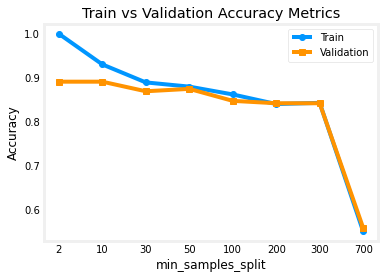

In [22]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Iterate over each value in min_samples_split_list to evaluate different split thresholds
for min_samples_split in min_samples_split_list:
    # Initialize the Random Forest model with the current min_samples_split value
    # random_state ensures reproducibility of results
    # The fit method trains the model on the training data (X_train, y_train)
    model = RandomForestClassifier(
        min_samples_split=min_samples_split,
        random_state=RANDOM_STATE
    ).fit(X_train, y_train)
    
    # Predict the labels for the training dataset using the trained model
    predictions_train = model.predict(X_train)  # Predicted values for the training set
    
    # Predict the labels for the validation dataset using the trained model
    predictions_val = model.predict(X_val)      # Predicted values for the validation set
    
    # Calculate the accuracy of the model on the training dataset
    # accuracy_score compares the predicted labels with the true labels (y_train)
    accuracy_train = accuracy_score(y_train, predictions_train)
    
    # Calculate the accuracy of the model on the validation dataset
    # accuracy_score compares the predicted labels with the true labels (y_val)
    accuracy_val = accuracy_score(y_val, predictions_val)
    
    # Append the training accuracy to the accuracy_list_train
    accuracy_list_train.append(accuracy_train)
    
    # Append the validation accuracy to the accuracy_list_val
    accuracy_list_val.append(accuracy_val)

# Set the title of the plot
plt.title('Train vs Validation Accuracy Metrics')

# Label the x-axis with the parameter being varied
plt.xlabel('min_samples_split')

# Label the y-axis with the metric being measured
plt.ylabel('Accuracy')

# Define the positions and labels for the x-ticks based on the number of min_samples_split values
plt.xticks(
    ticks=range(len(min_samples_split_list)),
    labels=min_samples_split_list
)

# Plot the training accuracy scores
plt.plot(accuracy_list_train, marker='o', label='Train')

# Plot the validation accuracy scores
plt.plot(accuracy_list_val, marker='s', label='Validation')

# Add a legend to distinguish between training and validation plots
plt.legend(['Train', 'Validation'])

# Display the plot
plt.show()


Notice that, even though the validation accuraty reaches is the same both at `min_samples_split = 2` and `min_samples_split = 10`, in the latter the difference in training and validation set reduces, showing less overfitting.

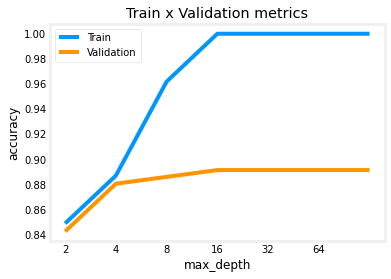

In [23]:
# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Iterate over each value in max_depth_list to evaluate different tree depths
for max_depth in max_depth_list:
    # Initialize and train the Random Forest model with the current max_depth
    # The fit method trains the model on the training data and returns the fitted estimator
    model = RandomForestClassifier(max_depth=max_depth,
                                   random_state=RANDOM_STATE).fit(X_train, y_train) 
    
    # Predict the labels for the training dataset using the trained model
    predictions_train = model.predict(X_train)  # The predicted values for the train dataset
    
    # Predict the labels for the validation dataset using the trained model
    predictions_val = model.predict(X_val)      # The predicted values for the validation dataset
    
    # Calculate the accuracy of the model on the training dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    
    # Calculate the accuracy of the model on the validation dataset
    accuracy_val = accuracy_score(predictions_val, y_val)
    
    # Append the training accuracy to the accuracy_list_train
    accuracy_list_train.append(accuracy_train)
    
    # Append the validation accuracy to the accuracy_list_val
    accuracy_list_val.append(accuracy_val)

# Set the title of the plot
plt.title('Train x Validation metrics')

# Label the x-axis with the hyperparameter being varied
plt.xlabel('max_depth')

# Label the y-axis with the performance metric
plt.ylabel('accuracy')

# Set the x-ticks to correspond to the max_depth values
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)

# Plot the training accuracy scores
plt.plot(accuracy_list_train)

# Plot the validation accuracy scores
plt.plot(accuracy_list_val)

# Add a legend to distinguish between training and validation accuracy lines
plt.legend(['Train', 'Validation'])


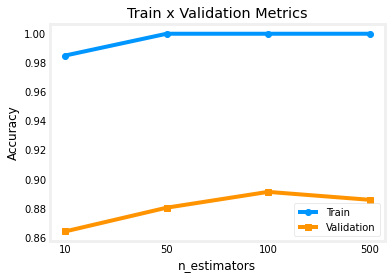

In [24]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier  # For building the Random Forest model
from sklearn.metrics import accuracy_score          # For evaluating model accuracy
import matplotlib.pyplot as plt                     # For plotting results

# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Iterate over each value in n_estimators_list to evaluate different numbers of trees in the forest
for n_estimators in n_estimators_list:
    # Initialize and train the Random Forest model with the current number of estimators
    # The fit method trains the model on the training data and returns the fitted estimator
    model = RandomForestClassifier(
        n_estimators=n_estimators,         # Number of trees in the forest
        random_state=RANDOM_STATE          # Ensures reproducibility of results
    ).fit(X_train, y_train)                 # Fits the model on training data
    
    # Predict the labels for the training dataset using the trained model
    predictions_train = model.predict(X_train)  # The predicted values for the training set
    
    # Predict the labels for the validation dataset using the trained model
    predictions_val = model.predict(X_val)      # The predicted values for the validation set
    
    # Calculate the accuracy of the model on the training dataset
    accuracy_train = accuracy_score(y_train, predictions_train)
    
    # Calculate the accuracy of the model on the validation dataset
    accuracy_val = accuracy_score(y_val, predictions_val)
    
    # Append the training accuracy to the accuracy_list_train
    accuracy_list_train.append(accuracy_train)
    
    # Append the validation accuracy to the accuracy_list_val
    accuracy_list_val.append(accuracy_val)

# Set the title of the plot
plt.title('Train x Validation Metrics')

# Label the x-axis with the hyperparameter being varied
plt.xlabel('n_estimators')

# Label the y-axis with the performance metric
plt.ylabel('Accuracy')

# Set the x-ticks to correspond to the n_estimators values
plt.xticks(
    ticks=range(len(n_estimators_list)),  # Positions of the ticks
    labels=n_estimators_list               # Labels for each tick
)

# Plot the training accuracy scores
plt.plot(accuracy_list_train, marker='o', label='Train')  # Adding marker 'o' for clarity

# Plot the validation accuracy scores
plt.plot(accuracy_list_val, marker='s', label='Validation')  # Adding marker 's' for clarity

# Add a legend to distinguish between training and validation accuracy lines
plt.legend(['Train', 'Validation'])

# Display the plot
plt.show()


**Integration of Feature Selection with Random Forests**:
- `SelectKBest` is a filter method for feature selection in Scikit-learn. It selects the top `k` features based on a specified scoring function. The scoring function evaluates each feature individually, assigning a score that reflects its importance or relevance to the target variable.
- Common scoring functions include:
    - f_classif: Computes the ANOVA F-value between each feature and the target for classification tasks.
    - chi2: Computes the chi-square statistic between each feature and the target for non-negative features.
    - mutual_info_classif: Estimates mutual information for classification tasks.
    - f_regression: Computes the correlation between each feature and the target for regression tasks.

Number of features available for selection: 20
Number of top features to select (k_features): 5

Accuracy Scores for Different min_samples_split Values:
   min_samples_split  Training Accuracy  Validation Accuracy
0                  2           0.840599             0.842391
1                 10           0.840599             0.842391
2                 30           0.840599             0.842391
3                 50           0.840599             0.842391
4                100           0.840599             0.842391
5                200           0.840599             0.842391
6                300           0.810627             0.826087
7                700           0.551771             0.559783


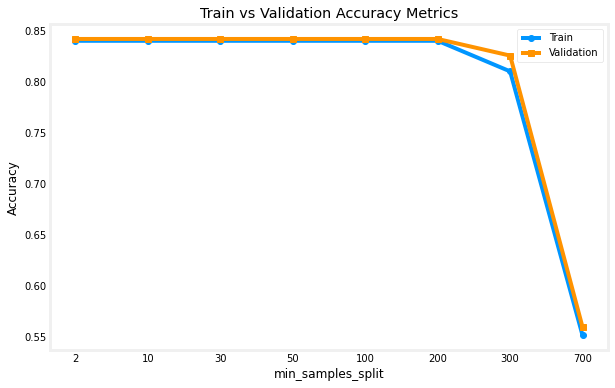


Best min_samples_split: 2
Validation Accuracy of Best Model: 0.84


In [25]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Define the number of top features to select
# Ensure that k_features does not exceed the number of available features
desired_k_features = 5
actual_num_features = X_train.shape[1]
k_features = min(desired_k_features, actual_num_features)
print(f"Number of features available for selection: {actual_num_features}")
print(f"Number of top features to select (k_features): {k_features}")

# Initialize empty lists to store accuracy scores for training and validation sets
accuracy_list_train = []
accuracy_list_val = []

# Initialize lists to keep track of the corresponding hyperparameters
selected_min_samples_split = []

# Feature Selection and Hyperparameter Tuning using a Pipeline
for min_samples_split in min_samples_split_list:
    # Create a pipeline that first selects the top k features, then fits the Random Forest
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif, k=k_features)),
        ('classifier', RandomForestClassifier(
            min_samples_split=min_samples_split,
            random_state=42,
            n_estimators=100  # You can adjust the number of trees as needed
        ))
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict the labels for the training dataset using the trained model
    predictions_train = pipeline.predict(X_train)  # Predicted values for the training set
    
    # Predict the labels for the validation dataset using the trained model
    predictions_val = pipeline.predict(X_val)      # Predicted values for the validation set
    
    # Calculate the accuracy of the model on the training dataset
    accuracy_train = accuracy_score(y_train, predictions_train)
    
    # Calculate the accuracy of the model on the validation dataset
    accuracy_val = accuracy_score(y_val, predictions_val)
    
    # Append the training accuracy to the accuracy_list_train
    accuracy_list_train.append(accuracy_train)
    
    # Append the validation accuracy to the accuracy_list_val
    accuracy_list_val.append(accuracy_val)
    
    # Keep track of the hyperparameters used
    selected_min_samples_split.append(min_samples_split)

# Convert the results into a DataFrame for easier analysis
results = pd.DataFrame({
    'min_samples_split': selected_min_samples_split,
    'Training Accuracy': accuracy_list_train,
    'Validation Accuracy': accuracy_list_val
})

# Display the results
print("\nAccuracy Scores for Different min_samples_split Values:")
print(results)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.title('Train vs Validation Accuracy Metrics')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')

# Set the x-ticks to correspond to the min_samples_split values
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)

# Plot the training accuracy scores with markers for clarity
plt.plot(accuracy_list_train, marker='o', label='Train')

# Plot the validation accuracy scores with markers for clarity
plt.plot(accuracy_list_val, marker='s', label='Validation')

# Add a legend to distinguish between training and validation plots
plt.legend(['Train', 'Validation'])

# Display the plot
plt.show()

# Identify the best hyperparameter based on validation accuracy
best_index = results['Validation Accuracy'].idxmax()
best_min_samples_split = results.loc[best_index, 'min_samples_split']
best_validation_accuracy = results.loc[best_index, 'Validation Accuracy']

print(f"\nBest min_samples_split: {best_min_samples_split}")
print(f"Validation Accuracy of Best Model: {best_validation_accuracy:.2f}")


Let's then fit a random forest with the following parameters:

 - max_depth: 16
 - min_samples_split: 10
 - n_estimators: 100

In [26]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [86]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.9022


Note that we are searching for the best value one hyperparameter while leaving the other hyperparameters at their default values.
- Ideally, we would want to check every combination of values for every hyperparameter that we are tuning.
- If we have 3 hyperparameters, and each hyperparameter has 4 values to try out, we should have a total of 4 x 4 x 4 = 64 combinations to try.
- When we only modify one hyperparameter while leaving the rest as their default value, we are trying 4 + 4 + 4 = 12 results. 
- To try out all combinations, we can use a sklearn implementation called GridSearchCV. GridSearchCV has a refit parameter that will automatically refit a model on the best combination so we will not need to program it explicitly. For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the hyperparameter grid
param_grid = {
    'feature_selection__k': [5, 10, 15, 20],                # Number of top features to select
    'classifier__min_samples_split': [2, 10, 30, 50, 100, 200, 300, 700],  # Minimum samples required to split an internal node
    'classifier__max_depth': [2, 4, 8, 16, 32, 64, None],   # Maximum depth of the tree
    'classifier__n_estimators': [10, 50, 100, 500]          # Number of trees in the forest
}

# Define the pipeline steps
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),  # Feature selection step
    ('classifier', RandomForestClassifier(random_state=42))   # Classification step
])

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,          # The pipeline to optimize
    param_grid=param_grid,       # The hyperparameter grid
    cv=5,                        # 5-fold cross-validation
    scoring='accuracy',          # Evaluation metric
    n_jobs=-1,                   # Utilize all available CPU cores
    verbose=2                    # Verbosity mode (controls the amount of messages)
)

# Fit GridSearchCV on the training data
print("\nStarting Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search completed.")

# Retrieve the best parameters and best score from GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\nBest Parameters Found:")
print(best_params)
print(f"\nBest Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions on the validation set
best_model = grid_search.best_estimator_
predictions_val = best_model.predict(X_val)

# Calculate validation accuracy
validation_accuracy = accuracy_score(y_val, predictions_val)
print(f"\nValidation Accuracy of Best Model: {validation_accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_val, predictions_val))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions_val))

# Convert the grid search results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display the first few rows of the results
print("\nGrid Search Results:")
print(results_df.head())

# Pivot the DataFrame for heatmap visualization
# Example: Fixing max_depth and k to visualize min_samples_split vs. n_estimators
fixed_max_depth = best_params['classifier__max_depth']
fixed_k = best_params['feature_selection__k']

# Filter results for the fixed max_depth and k
filtered_results = results_df[
    (results_df['param_classifier__max_depth'] == fixed_max_depth) &
    (results_df['param_feature_selection__k'] == fixed_k)
]

# Pivot the DataFrame to create a matrix for heatmap
pivot_table = filtered_results.pivot(
    index='param_classifier__min_samples_split', 
    columns='param_classifier__n_estimators', 
    values='mean_test_score'
)

# Display the pivot table
print("\nPivot Table for Heatmap:")
print(pivot_table)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap with seaborn
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".3f", 
    cmap="YlGnBu",
    linewidths=.5
)

# Set plot labels and title
plt.title(f'GridSearchCV Accuracy Heatmap\nmax_depth={fixed_max_depth}, k={fixed_k}')
plt.xlabel('n_estimators')
plt.ylabel('min_samples_split')

# Display the heatmap
plt.show()



Starting Grid Search...
Fitting 5 folds for each of 896 candidates, totalling 4480 fits


## 4.3 XGBoost

Next is the Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error. 

The model has the same parameters as a decision tree, plus the learning rate.
- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form `(X_val,y_val)`.
- On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
- Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop. 
- More iterations lead to more estimators, and more estimators can result in overfitting.  
- By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.

First, let's define a subset of our training set (we should not use the test set here).

In [27]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [28]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

We can then set a large number of estimators, because we can stop if the cost function stops decreasing.

Note some of the `.fit()` parameters:
- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have **several different tuples ov eval sets**. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.
  - The model keeps track of the round with the **best performance (lowest evaluation metric)**.  For example, let's say round 16 has the lowest evaluation metric so far.
  - Each successive round's evaluation metric is compared to the best metric.  **If the model goes 10 rounds where none have a better metric than the best one, then the model stops training**.
  - When you use early stopping during model training, the training process halts once the model's performance on a validation set stops improving for a specified number of consecutive iterations (early_stopping_rounds). However, the model retains the parameters from the final iteration at which training stopped, not from the iteration where it achieved its best performance. For example, **training stops at iteration 26, and the model retains the parameters from iteration 26, not from iteration 16**.
  - Note that this is different from returning the model's "best" state (from when the evaluation metric was the lowest).

In [29]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.64479
[1]	validation_0-logloss:0.60569
[2]	validation_0-logloss:0.57481
[3]	validation_0-logloss:0.54947
[4]	validation_0-logloss:0.52973
[5]	validation_0-logloss:0.51331
[6]	validation_0-logloss:0.49823
[7]	validation_0-logloss:0.48855
[8]	validation_0-logloss:0.47888
[9]	validation_0-logloss:0.47068
[10]	validation_0-logloss:0.46507
[11]	validation_0-logloss:0.45832
[12]	validation_0-logloss:0.45557
[13]	validation_0-logloss:0.45030
[14]	validation_0-logloss:0.44653
[15]	validation_0-logloss:0.44213
[16]	validation_0-logloss:0.43948
[17]	validation_0-logloss:0.44088
[18]	validation_0-logloss:0.44358
[19]	validation_0-logloss:0.44493
[20]	validation_0-logloss:0.44294
[21]	validation_0-logloss:0.44486
[22]	validation_0-logloss:0.44586
[23]	validation_0-logloss:0.44680
[24]	validation_0-logloss:0.44925
[25]	validation_0-logloss:0.45383


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=55,
              reg_alpha=0, reg_lambda=1, ...)

Even though we initialized the model to allow up to 500 estimators, the algorithm only fit 26 estimators (over 26 rounds of training).

To see why, let's look for the round of training that had the best performance (lowest evaluation metric).  You can either view the validation log loss metrics that were output above, or view the model's `.best_iteration` attribute:

In [30]:
xgb_model.best_iteration

16

The best round of training was round 16, with a log loss of 4.3948.  
- **For 10 rounds of training after that (from round 17 to 26), the log loss was higher than this**.
- Since we set `early_stopping_rounds` to 10, then by the 10th round where the log loss doesn't improve upon the best one, training stops.
- You can try out different values of `early_stopping_rounds` to verify this.  **If you set it to 20, for instance, the model stops training at round 36 (16 + 20)**.

In [31]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9251
Metrics test:
	Accuracy score: 0.8641


In this example, both Random Forest and XGBoost had similar performance (test accuracy).  

Congratulations, you have learned how to use Decision Tree, Random Forest from the scikit-learn library and XGBoost!